# Example model and use of the MOD PTB Microbiome challenge data

*Microbiome data* has a few quirks for machine learning applications. Here I will go through an example using what I feel is the best feature type to use for ML-microbiome studies. 

**TL/DR: Use the phylotype tables and/or alpha-diversity and/or pairwise distance and/or CST** instead of taxonomy or raw sequence-variant counts, as the former are the best harmonized across datasets. 

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from joblib import dump, load

I do my ML in python. The raw data are almost all in `csv` format, which should import into a variety of engines without fuss.

In [2]:
BASEDIR = './'

This is the path to the training data, in turn with the following subdirectories and files:

```
├── alpha_diversity
│  └── alpha_diversity.csv
├── community_state_types
│  ├── cst_valencia.csv
│  └── cst_valencia_w_taxons.csv
├── metadata
│  └── metadata.csv
├── pairwise_distance
│  ├── krd_distance_long.csv
│  └── krd_distance_wide.csv
├── phylotypes
│  ├── phylotype_nreads.1e0.csv
│  ├── phylotype_nreads.1e_1.csv
│  ├── phylotype_nreads.5e_1.csv
│  ├── phylotype_relabd.1e0.csv
│  ├── phylotype_relabd.1e_1.csv
│  ├── phylotype_relabd.5e_1.csv
│  ├── pt.1e-1.csv
│  ├── pt.1e0.csv
│  └── pt.5e-1.csv
├── sv_counts
│  └── sp_sv_long.csv
└── taxonomy
   ├── sv_taxonomy.csv
   ├── taxonomy_nreads.family.csv
   ├── taxonomy_nreads.genus.csv
   ├── taxonomy_nreads.species.csv
   ├── taxonomy_relabd.family.csv
   ├── taxonomy_relabd.genus.csv
   └── taxonomy_relabd.species.csv
```

In [3]:
metadata = pd.read_csv(
    os.path.join(BASEDIR, 'metadata', 'metadata.csv')
)
metadata.iloc[0:3]

,project,specimen,participant_id,was_term,delivery_wk,collect_wk,race,age,NIH Racial Category,NIH Ethnicity Category,was_preterm,was_early_preterm
0,A,A00001-05,A00001,False,38.0,33.0,American Indian,Unknown,American Indian or Alaska Native,Unknown,False,False
1,A,A00002-01,A00002,False,40.0,38.0,White,Unknown,White,Unknown,False,False
2,A,A00003-02,A00003,False,40.0,30.0,Asian-Japanese,Unknown,Asian,Unknown,False,False


**metadata** is provided for both the training and validation data sets. In our simple model today, we will not correct for things like age, gestational week of collection of the specimen, race, ethnicity, etc.

The validation data will lack the outcome data (e.g. `was_preterm`, `was_early_preterm`, `was_term` and `delivery_wk` columns).

For convenience, I convert the metadata into associative dictionaries to be able to quickly look up crucial values

In [4]:
# Get some per-participant values

specimen_participant = {
    sp: p
    for (sp, p) in zip(
        metadata.specimen,
        metadata.participant_id
    )
}
len(specimen_participant)

participant_preterm = {
    p: pt
    for (p, pt)
    in zip(
        metadata.participant_id,
        metadata.was_preterm
    )
}
participant_earlypreterm = {
    p: pt
    for (p, pt)
    in zip(
        metadata.participant_id,
        metadata.was_early_preterm
    )
}

Validation data will be limited to through 32 weeks for the preterm challenge and through 28 weeks for the early-preterm challenge. Let's do the same to the training data to be sure we are not relying upon later-in-pregnancy specimens we will not have access to in the validation set....

We will then further split the training data into a train-test set at 70-30 to be able to check on our models.

In [5]:
    # Make a split 70-30 *by participant* (to ensure no leak from a person's specimens between test/train)
    all_participants = sorted(metadata[metadata.collect_wk <= 32].participant_id.unique())
    early_participants = sorted(metadata[metadata.collect_wk <= 28].participant_id.unique())

    random.seed(12345)
    train_participants = random.sample(all_participants, int(0.7*len(all_participants)))
    test_participants = [p for p in all_participants if p not in train_participants]
    train_specimens = list(metadata[
        metadata.participant_id.apply(lambda p: p in train_participants) &
        (metadata.collect_wk <= 32)
    ].specimen)
    test_specimens = list(metadata[
        metadata.participant_id.apply(lambda p: p in test_participants) &
        (metadata.collect_wk <= 32)
    ].specimen)

    print(
        len(train_participants),
        len(test_participants),
        len(train_specimens),
        len(test_specimens)
    )
    #--- Now early PTB
    train_participants_early = random.sample(early_participants, int(0.7*len(early_participants)))
    test_participants_early = [p for p in early_participants if p not in train_participants_early]
    train_specimens_early = list(metadata[
        metadata.participant_id.apply(lambda p: p in train_participants_early) &
        (metadata.collect_wk <= 28)
    ].specimen)
    test_specimens_early = list(metadata[
        metadata.participant_id.apply(lambda p: p in test_participants_early) &
        (metadata.collect_wk <= 28)
    ].specimen)

    print(
        len(train_participants_early),
        len(test_participants_early),
        len(train_specimens_early),
        len(test_specimens_early)
    )    

849 365 2240 949
809 348 1999 869


In [6]:
    # Make an outcome lookup dict for preterm / not-preterm

    preterm_tf = {
        sp: bool(t)
        for (sp, t) in
        zip(
            metadata[metadata.participant_id.apply(lambda p: p in all_participants)].specimen,
            metadata[metadata.participant_id.apply(lambda p: p in all_participants)].was_preterm
        )
    }

    # Make our test-train splits on the outcome data

    preterm_tf_train = [
        preterm_tf.get(p)
        for p in 
        train_specimens
    ]
    preterm_tf_test = [
        preterm_tf.get(p)
        for p in 
        test_specimens
    ]

In [7]:
    # Make an outcome lookup dict for early_preterm / not-early_preterm

    early_preterm_tf = {
        sp: bool(t)
        for (sp, t) in
        zip(
            metadata[metadata.participant_id.apply(lambda p: p in early_participants)].specimen,
            metadata[metadata.participant_id.apply(lambda p: p in early_participants)].was_early_preterm
        )
    }

    # Make our test-train splits on the outcome data

    early_preterm_tf_train = [
        early_preterm_tf.get(p)
        for p in 
        train_specimens_early
    ]
    early_preterm_tf_test = [
        early_preterm_tf.get(p)
        for p in 
        test_specimens_early
    ]

## For this model, we will ONLY use the phylotype-relative abundance data.

Phylotypes are a cross-study feature, representing either a microbe, or very closely related (in evolutionary time) set of microbes. 

Phylotypes are groups of 16S rRNA sequence variants that have been clustered together based on the phylogenetic distance between these sequence variants after placement onto a tree of full-length 16S rRNA alleles. These were generated using the [MaLiAmPi pipeline](https://github.com/jgolob/maliampi).

If you are not sure which feature to use, I suggest *trying your modeling first with phylotypes as the feature*.


In [8]:
    # Load in the phylotype data
    pt_ra_1e_1 = pd.read_csv(
        os.path.join(BASEDIR, 'phylotypes', 'phylotype_relabd.1e_1.csv'),
        index_col=0
    )
    pt_ra_5e_1 = pd.read_csv(
        os.path.join(BASEDIR, 'phylotypes', 'phylotype_relabd.5e_1.csv'),
        index_col=0
    )
    pt_ra_1e0 = pd.read_csv(
        os.path.join(BASEDIR, 'phylotypes', 'phylotype_relabd.1e0.csv'),
        index_col=0
    )


These phylotype feature tables are very akin to OTU tables used in other forms of microbiome analysis or a FPKM table from a transcriptioanl data set. Each specimen is a row. Each feature gets a column. The values are the relative transcripts that belong to that feature for that specimen....

In [9]:
pt_ra_5e_1.iloc[0:3]

,pt__00001,pt__00002,pt__00003,pt__00004,pt__00005,pt__00006,pt__00007,pt__00008,pt__00009,pt__00010,...,pt__03615,pt__03616,pt__03617,pt__03618,pt__03619,pt__03620,pt__03621,pt__03622,pt__03623,pt__03624
specimen,,,,,,,,,,,,,,,,,,,,,
A00001-05,0.000525,0.083465,0.121260,0.0,0.0,0.000000,0.0,0.0,0.007349,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00002-01,0.000000,0.803188,0.001226,0.0,0.0,0.000613,0.0,0.0,0.009810,0.0,...,0.000613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00003-02,0.001079,0.960708,0.002591,0.0,0.0,0.011442,0.0,0.0,0.000216,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Sum up by row and the total is always 1.0, as these are normalized relative abundance. The `nreads` versions of these same tables have the raw read counts per specimen, suitable for things like beta-binomial modeling, etc. 

In [10]:
pt_ra_5e_1.T.sum().iloc[0:3]

specimen
A00001-05    1.0
A00002-01    1.0
A00003-02    1.0
dtype: float64

You can see there are *three* tables loaded, one clustering at a different phylogenetic distance. This way, we can see the effect of this hyperparameter: the phylogenetic distance used to cluster together sequence variants.
    

In [11]:
    # Test / train split the phylotype data at three different phylogenetic distances for clustering:
    # 1 (1e0)
    # 0.5 (5e-1)
    # 0.1 (1e-1)
    # The lower distances keep more information about strain differences, 
    # but make integration of different studies more challenging
    pt_ra_1e_1_train = pt_ra_1e_1.loc[train_specimens]
    pt_ra_1e_1_test = pt_ra_1e_1.loc[test_specimens]

    pt_ra_5e_1_train = pt_ra_5e_1.loc[train_specimens]
    pt_ra_5e_1_test = pt_ra_5e_1.loc[test_specimens]

    pt_ra_1e0_train = pt_ra_1e0.loc[train_specimens]
    pt_ra_1e0_test = pt_ra_1e0.loc[test_specimens]
    
    # -- Early
    pt_ra_1e_1_train_early = pt_ra_1e_1.loc[train_specimens_early]
    pt_ra_1e_1_test_early = pt_ra_1e_1.loc[test_specimens_early]

    pt_ra_5e_1_train_early = pt_ra_5e_1.loc[train_specimens_early]
    pt_ra_5e_1_test_early = pt_ra_5e_1.loc[test_specimens_early]

    pt_ra_1e0_train_early = pt_ra_1e0.loc[train_specimens_early]
    pt_ra_1e0_test_early = pt_ra_1e0.loc[test_specimens_early]

This is the actual modeling, with a random forest classifer. This is a very basic model with no optimization of hyperparameters. The intent was just to make a model suitable for developing the validation pipelines.

In [12]:
pt_rf_model_1e0_preterm = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    random_state=12345
).fit(
    X=pt_ra_1e0_train,
    y=preterm_tf_train
)

# And now score the model on the training and test specimens....
print(
    pt_rf_model_1e0_preterm.score(
        X=pt_ra_1e0_train,
        y=preterm_tf_train
    ),
    pt_rf_model_1e0_preterm.score(
        X=pt_ra_1e0_test,
        y=preterm_tf_test
    ),

)

pt_rf_model_1e0_early_preterm = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    random_state=12345
).fit(
    X=pt_ra_1e0_train_early,
    y=early_preterm_tf_train
)

# And now score the model on the training and test specimens....
print(
    pt_rf_model_1e0_early_preterm.score(
        X=pt_ra_1e0_train_early,
        y=early_preterm_tf_train
    ),
    pt_rf_model_1e0_early_preterm.score(
        X=pt_ra_1e0_test_early,
        y=early_preterm_tf_test
    ),

)


0.9816964285714286 0.7723919915700738
0.9944972486243121 0.8952819332566168


In [13]:
pt_rf_model_5e_1_preterm = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    random_state=12345
).fit(
    X=pt_ra_5e_1_train,
    y=preterm_tf_train
)

# And now score the model on the training and test specimens....
print(
    pt_rf_model_5e_1_preterm.score(
        X=pt_ra_5e_1_train,
        y=preterm_tf_train
    ),
    pt_rf_model_5e_1_preterm.score(
        X=pt_ra_5e_1_test,
        y=preterm_tf_test
    ),

)

pt_rf_model_5e_1_early_preterm = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    random_state=12345
).fit(
    X=pt_ra_5e_1_train_early,
    y=early_preterm_tf_train
)

# And now score the model on the training and test specimens....
print(
    pt_rf_model_5e_1_early_preterm.score(
        X=pt_ra_5e_1_train_early,
        y=early_preterm_tf_train
    ),
    pt_rf_model_5e_1_early_preterm.score(
        X=pt_ra_5e_1_test_early,
        y=early_preterm_tf_test
    ),

)


0.9910714285714286 0.7660695468914647
0.9969984992496248 0.8883774453394706


In [14]:
pt_rf_model_1e_1_preterm = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    random_state=12345
).fit(
    X=pt_ra_1e_1_train,
    y=preterm_tf_train
)

# And now score the model on the training and test specimens....
print(
    pt_rf_model_1e_1_preterm.score(
        X=pt_ra_1e_1_train,
        y=preterm_tf_train
    ),
    pt_rf_model_1e_1_preterm.score(
        X=pt_ra_1e_1_test,
        y=preterm_tf_test
    ),

)

pt_rf_model_1e_1_early_preterm = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    random_state=12345
).fit(
    X=pt_ra_1e_1_train_early,
    y=early_preterm_tf_train
)

# And now score the model on the training and test specimens....
print(
    pt_rf_model_1e_1_early_preterm.score(
        X=pt_ra_1e_1_train_early,
        y=early_preterm_tf_train
    ),
    pt_rf_model_1e_1_early_preterm.score(
        X=pt_ra_1e_1_test_early,
        y=early_preterm_tf_test
    ),

)


0.990625 0.7650158061116965
0.9969984992496248 0.8906789413118527


Now let's plot some familiar ROC curves...

/home/lu/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/lu/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/lu/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be

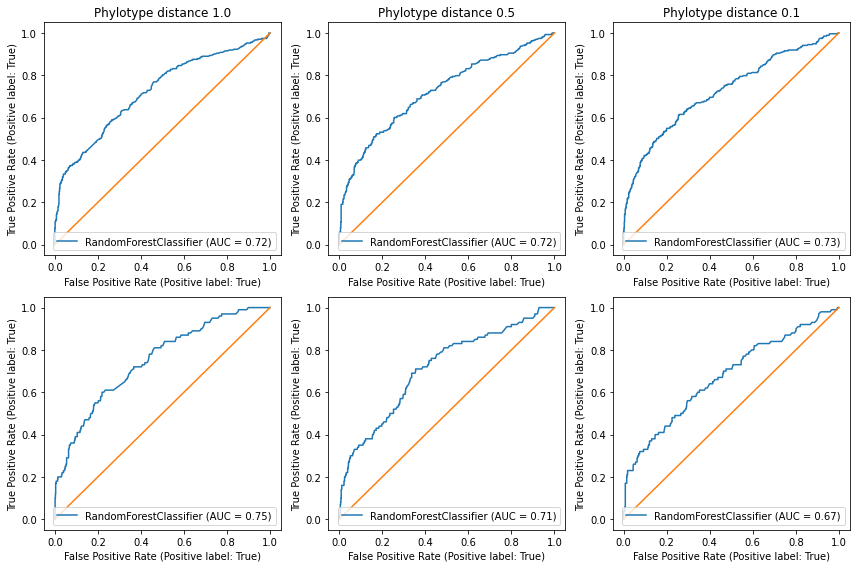

In [15]:
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,8))

    plot_roc_curve(
        pt_rf_model_1e0_preterm,
        X=pt_ra_1e0_test,
        y=preterm_tf_test,
        ax=axes[0,0]
    )
    axes[0,0].plot([0,1], [0,1])
    
    plot_roc_curve(
        pt_rf_model_1e0_early_preterm,
        X=pt_ra_1e0_test_early,
        y=early_preterm_tf_test,
        ax=axes[1,0]
    )
    axes[1,0].plot([0,1], [0,1])
    axes[0,0].set_title("Phylotype distance 1.0")
    
    axes[0,0].set_title("Phylotype distance 1.0")
    
    ## --
    plot_roc_curve(
        pt_rf_model_5e_1_preterm,
        X=pt_ra_5e_1_test,
        y=preterm_tf_test,
        ax=axes[0,1]
    )

    
    plot_roc_curve(
        pt_rf_model_5e_1_early_preterm,
        X=pt_ra_5e_1_test_early,
        y=early_preterm_tf_test,
        ax=axes[1,1]
    )    
    
    axes[0,1].plot([0,1], [0,1])
    axes[1,1].plot([0,1], [0,1])
    axes[0,1].set_title("Phylotype distance 0.5")

    #--
    plot_roc_curve(
        pt_rf_model_1e_1_preterm,
        X=pt_ra_1e_1_test,
        y=preterm_tf_test,
        ax=axes[0,2]
    )

    
    plot_roc_curve(
        pt_rf_model_1e_1_early_preterm,
        X=pt_ra_1e_1_test_early,
        y=early_preterm_tf_test,
        ax=axes[1,2]
    )  
    axes[1,2].plot([0,1], [0,1])
    axes[0,2].plot([0,1], [0,1])
    axes[0,2].set_title("Phylotype distance 0.1")


    plt.tight_layout()
    plt.show()

My conculusion was the models all perform reasonably well, and similarly / insensitive over this range of the the phylogenetic distance hyperparameter (0.1, 0.5, and 1). 

## Dump models using the joblib dumps to be placed into the docker container

For the challenge, these dumped model binaries will be placed into the docker container, loaded, and then applied to the phylotype tables from the validation data.

In [16]:
dump(pt_rf_model_1e0_preterm, 'models/preterm.rf_pt_1e0.save')
dump(pt_rf_model_1e0_early_preterm, 'models/early_preterm.rf_pt_1e0.save')
dump(pt_rf_model_1e_1_preterm, 'models/preterm.rf_pt_1e_1.save')
dump(pt_rf_model_1e_1_early_preterm, 'models/early_preterm.rf_pt_1e_1.save')
dump(pt_rf_model_5e_1_preterm, 'models/preterm.rf_pt_5e_1.save')
dump(pt_rf_model_5e_1_early_preterm, 'models/early_preterm.rf_pt_5e_1.save')


FileNotFoundError: [Errno 2] No such file or directory: 'models/preterm.rf_pt_1e0.save'

There is repeated sampling, so what we *really* need is some way to predict on a per-participant not per-specimen basis. So, here is some sample code that *also* is used in the docker container to take the model's per-specimen prediction and convert it into a per-participant prediction.

In [ ]:
pt_5e_1_predicts = pd.DataFrame(
    index=pt_ra_5e_1_test.index,
)
pt_5e_1_predicts['was_early_preterm'] = pt_rf_model_5e_1_early_preterm.predict(
        pt_ra_5e_1_test
    )
pt_5e_1_predicts['was_preterm'] = pt_rf_model_5e_1_preterm.predict(
        pt_ra_5e_1_test
    )
pt_5e_1_predicts['participant'] = pt_5e_1_predicts.index.map(specimen_participant.get)
pt_5e_1_predicts.iloc[0:3]

.. This again can be done better. Here we just take the maximum for each participant's specimens (i.e. if ANY are scored as preterm the entire participant is scored as preterm ...

In [ ]:
pt_5e_1_predicts_by_participant = pt_5e_1_predicts.groupby('participant').max()
pt_5e_1_predicts_by_participant.iloc[0:3]

In [ ]:
print(
    roc_auc_score(
        y_true=[
            participant_preterm.get(p) for p in pt_5e_1_predicts_by_participant.index
        ],
        y_score=pt_5e_1_predicts_by_participant.was_preterm
    ),
    roc_auc_score(
        y_true=[
            participant_earlypreterm.get(p) for p in pt_5e_1_predicts_by_participant.index
        ],
        y_score=pt_5e_1_predicts_by_participant.was_early_preterm
    )
)

Same story for probability prediction of preterm.... We need to summarize this by participant from model scores by specimen.

In [ ]:
    model = pt_rf_model_5e_1_early_preterm
    pt = pt_ra_5e_1_test_early
    predicts = pd.DataFrame(
        [1 if p else 0 for p in model.predict(pt)],
        index=pt.index,
        columns=[f'was_early_preterm']
    )
    predicts['probability'] = [
        v[1] for v in 
        model.predict_proba(
            pt
        )
    ]
    predicts['participant'] = predicts.index.map(specimen_participant.get)
    
    predicts.iloc[0:3]

In [ ]:
predicts[
    predicts.was_early_preterm == 1
].iloc[0:3]

In [ ]:
predicts_by_participant = predicts.groupby('participant').max().reset_index()
predicts_by_participant['was_early_preterm'] = predicts_by_participant['was_early_preterm'].astype(int)
predicts_by_participant.iloc[0:3]

In [ ]:
predicts_by_participant[
    predicts_by_participant.was_early_preterm == 1
].iloc[0:3]